In [1]:
import os
import sv as SV
import numpy as np
import astropy.table as atable

from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# load compiled zsuccess rates to file
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
#dat_dir = '/global/cscratch1/sd/mjwilson/desi/BGS/bgs-cmxsv/'
#dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'


sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.v4.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.v4.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.v3.fits'))

(0.0, 10000.0)

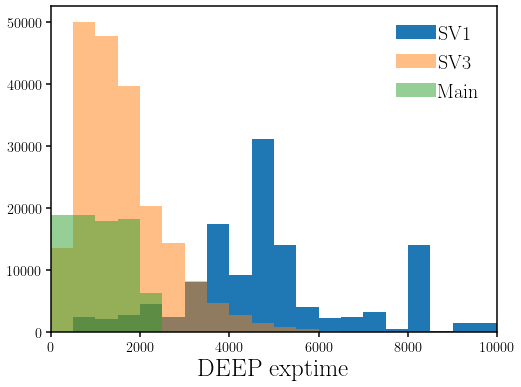

In [4]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

_ = sub.hist(sv1_gals['DEEP_EXPTIME'], range=(0., 1e4), bins=20, label='SV1', histtype='stepfilled')
_ = sub.hist(sv3_gals['DEEP_EXPTIME'], range=(0., 1e4), bins=20, alpha=0.5, label='SV3', histtype='stepfilled')
_ = sub.hist(main_gals['DEEP_EXPTIME'], range=(0., 1e4), bins=20, alpha=0.5, label='Main', histtype='stepfilled')

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)

sub.set_xlabel('DEEP exptime', fontsize=25)

sub.set_xlim(0., 1e4)

## only use exposures with reasonable DEEP truth table

In [5]:
sv1_deep  = (sv1_gals['DEEP_EXPTIME'] > 2000) 
sv3_deep  = np.isin(sv3_gals['PRIORITY'].data, np.array([102100, 102000])) & (sv3_gals['EFFTIME_TSNR2_BGS'] > 100)

np.mean(sv1_deep), np.mean(sv3_deep)

(0.9415918811048426, 0.600423039534168)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'DEEP EFFTIME SPEC')

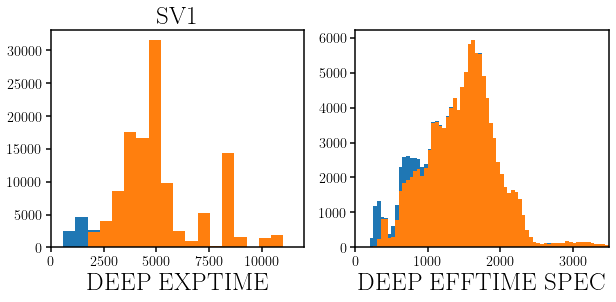

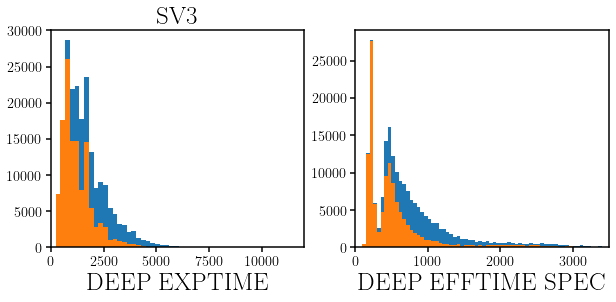

In [6]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
_ = sub.hist(sv1_gals['DEEP_EXPTIME'].data, bins=np.linspace(0.0, 1.1e4, 20))
_ = sub.hist(sv1_gals['DEEP_EXPTIME'].data[sv1_deep], bins=np.linspace(0.0, 1.1e4, 20))
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim(0.0, 1.2e4)
sub.set_xlabel('DEEP EXPTIME', fontsize=25)
sub.set_title('SV1', fontsize=25)
sub = fig.add_subplot(122)
_ = sub.hist(sv1_gals['DEEP_EFFTIME_TSNR2_BGS'], bins=np.arange(0.0, 1.e4, 50.))
_ = sub.hist(sv1_gals['DEEP_EFFTIME_TSNR2_BGS'][sv1_deep], bins=np.arange(0.0, 1.e4, 50.))
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim(0.0, 3.5e3)
sub.set_xlabel('DEEP EFFTIME SPEC', fontsize=25)


fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
_ = sub.hist(sv3_gals['DEEP_EXPTIME'].data, bins=np.linspace(0.0, 1.1e4, 50))
_ = sub.hist(sv3_gals['DEEP_EXPTIME'].data[sv3_deep], bins=np.linspace(0.0, 1.1e4, 50))
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim(0.0, 1.2e4)
sub.set_xlabel('DEEP EXPTIME', fontsize=25)
sub.set_title('SV3', fontsize=25)
sub = fig.add_subplot(122)
_ = sub.hist(sv3_gals['DEEP_EFFTIME_TSNR2_BGS'], bins=np.arange(0.0, 1.e4, 50.))
_ = sub.hist(sv3_gals['DEEP_EFFTIME_TSNR2_BGS'][sv3_deep], bins=np.arange(0.0, 1.e4, 50.))
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim(0.0, 3.5e3)
sub.set_xlabel('DEEP EFFTIME SPEC', fontsize=25)

In [7]:
sv1_gmag = sv1_gals['GMAG_DRED'] 
sv1_rmag = sv1_gals['RMAG_DRED'] 
sv1_zmag = sv1_gals['ZMAG_DRED']
sv1_rfib = sv1_gals['FIBER_RMAG_DRED']
sv1_colr = sv1_gals['FAINT_FIBCOL']

sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0

sv3_gmag = sv3_gals['GMAG_DRED']
sv3_rmag = sv3_gals['RMAG_DRED']
sv3_zmag = sv3_gals['ZMAG_DRED']
sv3_rfib = sv3_gals['FIBER_RMAG_DRED']
sv3_colr = sv3_gals['FAINT_FIBCOL']

sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

In [12]:
print('SV3 BGS BRIGHT Z-SUCCESS RATE %.3f' % np.mean(sv3_gals['ZSUCCESS'][sv3_deep & sv3_brgt]))
print('SV3 BGS FAINT Z-SUCCESS RATE %.3f' % np.mean(sv3_gals['ZSUCCESS'][sv3_deep & sv3_fain]))

SV3 BGS BRIGHT Z-SUCCESS RATE 0.982
SV3 BGS FAINT Z-SUCCESS RATE 0.972


sv1
[1.         1.         1.         0.98347107 0.99588477 0.98564593
 0.98769772 0.99226306 0.99126522 0.98334572 0.97742247 0.96056367
 0.91770773 0.80279928]
sv3
[1.         1.         1.         0.98726115 1.         1.
 1.         0.99233491 0.99192797 0.99657904 0.99033194 0.98655948
 0.97390511 0.9772175  0.95897603]


(0.6, 1.08)

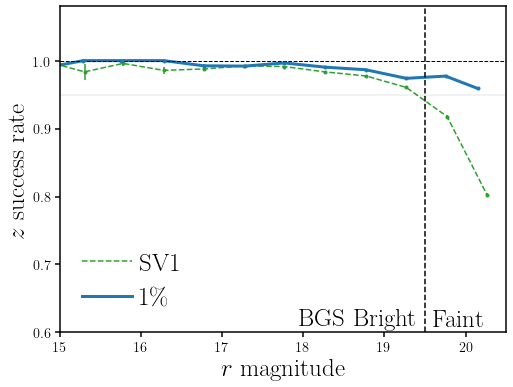

In [8]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq], range=(12, 22), nbins=20, bin_min=10)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C2')
print('sv1')
print(zsrate)
sub.plot(rmid, zsrate, c='C2', ls='--', label='SV1')

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv3_rmag[sv3_deep], sv3_gals['ZSUCCESS'][sv3_deep], range=(12, 22), nbins=20, bin_min=10)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C0')
print('sv3')
print(zsrate)
sub.plot(rmid, zsrate, c='C0', lw=3, label='$1\%$')

sub.axhline(1.0, color='k', linestyle='--', lw=1)

#for hh in np.arange(1., 0.94, -0.01):
sub.axhline(0.95, color='k', linestyle='-', lw=0.1)

sub.axvline(19.5, color='k', linestyle='--')
sub.text(19.4, 0.61, 'BGS Bright', ha='right', fontsize=25, rotation=0)
sub.text(19.6, 0.61, 'Faint', ha='left', fontsize=25, rotation=0)

sub.legend(loc='lower left', fontsize=25, handletextpad=0.3)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 20.5)
sub.set_ylabel('$z$ success rate', fontsize=25)
sub.set_ylim(0.6, 1.08)

(16.0, 26.0)

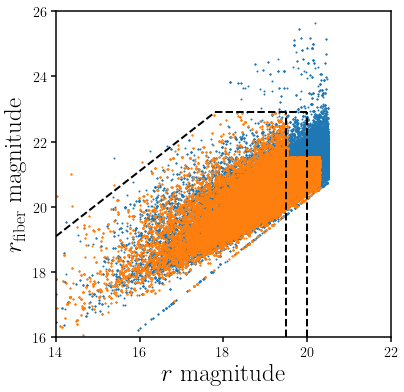

In [9]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.scatter(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_rfib[sv1_deep & ~sv1_lowq], c='C0', s=1)
sub.scatter(sv3_rmag[sv3_deep], sv3_rfib[sv3_deep], c='C1', s=1)

sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(14, 22)
sub.set_ylabel(r'$r_{\rm fiber}$ magnitude', fontsize=25)
sub.set_ylim(16, 26)

In [10]:
clrs = [] 
for i in range(10): 
    clrs.append((0, 0, 0.1 * i, 1))
    #clrs.append((0.05 * i, 0.05 * i, 0.05 * i, 1))
clrs = clrs[::-1]
cmap = mpl.colors.ListedColormap(clrs)#[(0,0,0,0.), (0,0,0,0.95)])

In [11]:
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
clrs1 = plt.cm.Blues(np.linspace(0.5, 1, 5))
clrs2 = plt.cm.Spectral_r(np.linspace(0.2, 1, 95))
#clrs2 = plt.cm.hot_r(np.linspace(0.2, 0.8, 95))

# combine them and build a new colormap
colors = np.vstack((clrs2, clrs1))
mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

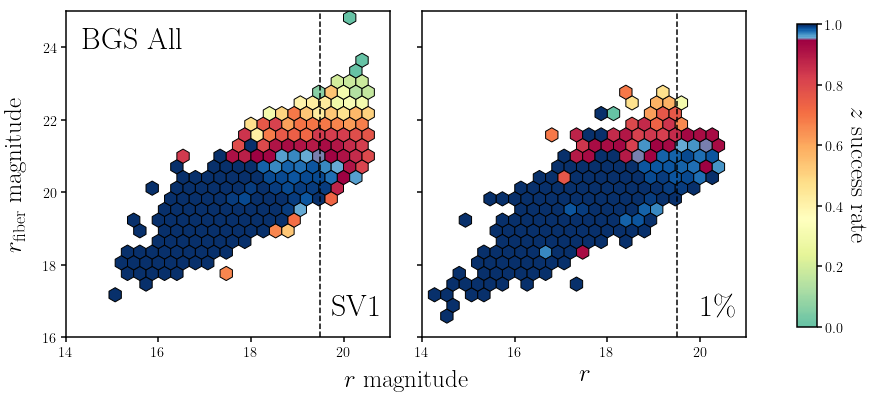

In [12]:
fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)

hb = sub.hexbin(sv1_rmag[sv1_deep & ~sv1_lowq], sv1_rfib[sv1_deep & ~sv1_lowq], C=sv1_gals['ZSUCCESS'][sv1_deep & ~sv1_lowq].astype(float), 
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(14, 22, 16, 26), gridsize=30, vmin=0., vmax=1., mincnt=10, cmap=mymap)#'Spectral_r')
sub.axvline(19.5, color='k', ls='--')
#sub.scatter([], [], marker='h', s=300, label='SV1', c='C3', alpha=0.75)
#sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C3', edgecolor='k')
sub.text(0.05, 0.95, r'BGS All', ha='left', va='top', transform=sub.transAxes, fontsize=30)
sub.text(0.975, 0.05, 'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

#sub.text(14.5, 20.3, 'fiber-magnitude cut', rotation=39, fontsize=15)
#sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
#sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=3)
#sub.plot([20., 22.], [22.9, 24.9], c='k', ls='--', lw=3)

#sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
#sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlim(14, 21)
sub.set_xticks([14, 16, 18, 20])
sub.set_ylim(16, 25)
sub.set_yticks([16, 18, 20, 22, 24])

sub = fig.add_subplot(122)

hb = sub.hexbin(sv3_rmag[sv3_deep], sv3_rfib[sv3_deep], C=sv3_gals['ZSUCCESS'][sv3_deep].astype(float),
                edgecolors='k', linewidth=1., reduce_C_function=np.mean, extent=(14, 22, 16, 26), gridsize=30, vmin=0., vmax=1., mincnt=10, cmap=mymap)
sub.axvline(19.5, color='k', ls='--')

sub.text(0.975, 0.05, '$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)
sub.set_xlabel('$r$', fontsize=25)
sub.set_xlim(14, 21)
sub.set_xticks([14, 16, 18, 20])
sub.set_ylim(16, 25)
sub.set_yticks([16, 18, 20, 22, 24])
sub.set_yticklabels([])


bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r$ magnitude', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.8)


cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/zsuccess_rmag_rfib.pdf', bbox_inches='tight')

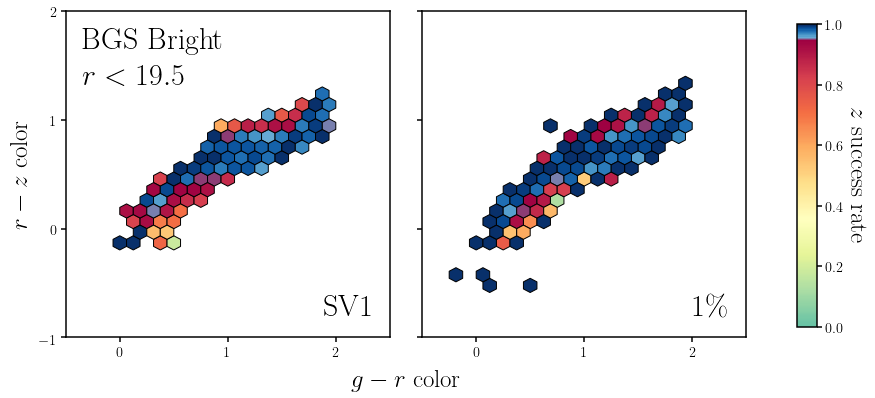

In [13]:
fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)

hb = sub.hexbin((sv1_gmag - sv1_rmag)[sv1_deep & sv1_brgt], (sv1_rmag - sv1_zmag)[sv1_deep & sv1_brgt], C=sv1_gals['ZSUCCESS'][sv1_deep & sv1_brgt].astype(float), 
                reduce_C_function=np.mean, extent=(-1, 4, -1.5, 3), gridsize=40, vmin=0., vmax=1., mincnt=10, 
                cmap=mymap, edgecolors='k', linewidth=1.)
sub.text(0.05, 0.95, r'BGS Bright', ha='left', va='top', transform=sub.transAxes, fontsize=30)
sub.text(0.05, 0.84, r'$r < 19.5$', ha='left', va='top', transform=sub.transAxes, fontsize=30)
sub.text(0.95, 0.05, 'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-0.5, 2.5)
sub.set_ylim(-1, 2)
sub.set_xticks([ 0., 1, 2.])
sub.set_yticks([-1, 0., 1., 2.])

sub = fig.add_subplot(122)

hb = sub.hexbin((sv3_gmag - sv3_rmag)[sv3_deep & sv3_brgt], (sv3_rmag - sv3_zmag)[sv3_deep & sv3_brgt], C=sv3_gals['ZSUCCESS'][sv3_deep & sv3_brgt].astype(float), 
                reduce_C_function=np.mean, extent=(-1, 4, -1.5, 3), gridsize=40, vmin=0., vmax=1., mincnt=10, 
                cmap=mymap, edgecolors='k', linewidth=1.)

sub.text(0.95, 0.05, '$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(-0.5, 2.5)
sub.set_ylim(-1, 2)
sub.set_yticklabels([])
sub.set_xticks([0., 1., 2.])
sub.set_yticks([-1, 0., 1., 2.])


bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$g - r$ color', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'$r - z$ color', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/zsuccess_gr_rz.pdf', bbox_inches='tight')

(19.5, 23.3)

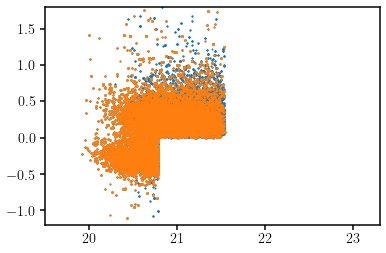

In [26]:
plt.scatter(sv3_rfib[sv3_deep & sv3_fain], sv3_colr[sv3_deep & sv3_fain], s=1)
plt.scatter(sv3_rfib[sv3_deep & sv3_fain & (sv3_rmag < 20.)], sv3_colr[sv3_deep & sv3_fain & (sv3_rmag < 20.)], s=1)
#plt.scatter(sv1_rfib[sv1_deep & sv1_fain], sv1_colr[sv1_deep & sv1_fain], s=1)

plt.ylim(-1.2, 1.8)
plt.xlim(19.5, 23.3)

In [ ]:
fig = plt.figure(figsize=(15,6))
sub = fig.add_subplot(121)

hb = sub.hexbin(sv1_rfib[sv1_deep & sv1_fain], sv1_colr[sv1_deep & sv1_fain], C=sv1_gals['ZSUCCESS'][sv1_deep & sv1_fain].astype(float),
                reduce_C_function=np.mean, extent=(19.5, 23.3, -1.2, 1.8), gridsize=30, vmin=0., vmax=1., mincnt=10,
                cmap=mymap, edgecolors='k', linewidth=1.)

sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

sub.text(0.05, 0.95, r'BGS Faint', ha='left', va='top', transform=sub.transAxes, fontsize=30)
sub.text(0.95, 0.05, 'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
sub.set_ylim(-1.2, 1.8)
sub.set_xlim(19.5, 23.3)
sub.set_xticks([20, 21, 22, 23])


sub = fig.add_subplot(122)
hb = sub.hexbin(sv3_rfib[sv3_deep & sv3_fain], sv3_colr[sv3_deep & sv3_fain], C=sv3_gals['ZSUCCESS'][sv3_deep & sv3_fain].astype(float),
                reduce_C_function=np.mean, extent=(19.5, 23.3, -1.2, 1.8), gridsize=30, vmin=0., vmax=1., mincnt=10,
                cmap=mymap, edgecolors='k', linewidth=1.)
sub.text(0.95, 0.05, '$1\%$', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
sub.set_ylim(-1.2, 1.8)
sub.set_xlim(19.5, 23.3)
sub.set_xticks([20, 21, 22, 23])
sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'$(z - w1) - 1.2 (g - r) + 1.2$', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/zsuccess_rfib_col.pdf', bbox_inches='tight')

In [20]:
sv1_not_rfibcut = ((sv1_rfib > (5.1 + sv1_rmag)) & (sv1_rmag < 17.8)) | ((sv1_rfib > 22.9)  & (sv1_rmag < 20.0) & (sv1_rmag > 17.8))

(16.0, 26.0)

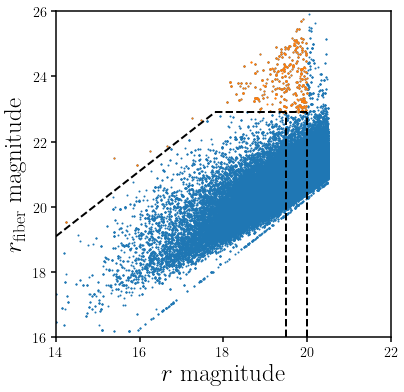

In [23]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.scatter(sv1_rmag[sv1_deep], sv1_rfib[sv1_deep], c='C0', s=1)
sub.scatter(sv1_rmag[sv1_not_rfibcut], sv1_rfib[sv1_not_rfibcut], c='C1', s=1)

sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.0], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(14, 22)
sub.set_ylabel(r'$r_{\rm fiber}$ magnitude', fontsize=25)
sub.set_ylim(16, 26)

In [24]:
np.sum(sv1_deep & sv1_not_rfibcut)

526

sv1
[0.18518519 0.05882353 0.10526316 0.14084507]


Text(0, 0.5, '$z$ success rate')

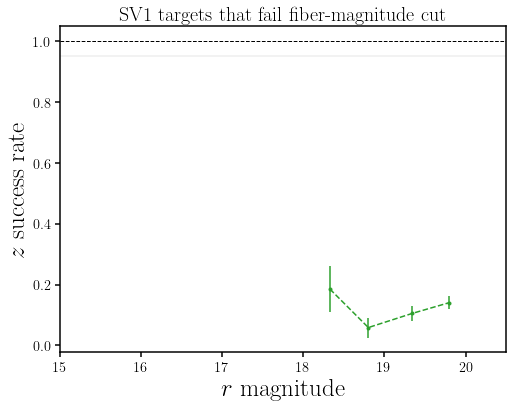

In [30]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

rmid, zsrate, err_zsrate = SV.zsuccess_rate(sv1_rmag[sv1_deep & sv1_not_rfibcut], sv1_gals['ZSUCCESS'][sv1_deep & sv1_not_rfibcut], range=(12, 22), nbins=20, bin_min=2)
sub.errorbar(rmid, zsrate, yerr=err_zsrate, fmt='.C2')
print('sv1')
print(zsrate)
sub.plot(rmid, zsrate, c='C2', ls='--')

sub.axhline(1.0, color='k', linestyle='--', lw=1)

#for hh in np.arange(1., 0.94, -0.01):
sub.axhline(0.95, color='k', linestyle='-', lw=0.1)

sub.set_title('SV1 targets that fail fiber-magnitude cut', fontsize=20)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 20.5)
sub.set_ylabel('$z$ success rate', fontsize=25)
#sub.set_ylim(0.8, 1.08)

# Done.